In [1]:
from iuvs import io, scaling, plotting

In [2]:
def calc_4_to_3(width):
    height = width * 3 / 4
    return (width, height)

In [3]:
# %matplotlib qt
plt.style.use('bmh')
plt.rcParams['figure.figsize']= calc_4_to_3(9)
plt.rcParams['image.aspect'] = 'auto'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['lines.linewidth'] = 1

In [4]:
def img_profile_and_stats(img, l1b, title, spatialslice, spectralslice,
                          zmin=None, zmax=None, 
                          spatial=None, spectral=None,
                          ):
    fig, axes = plt.subplots(2, 2)
    if spatial is None:
        spatial = img.shape[0]//2
    if spectral is None:
        spectral = img.shape[1]//2

    
    no_nans = img[~np.isnan(img)]
    sliced = img[spatialslice, spectralslice]
    to_hist = sliced[~np.isnan(sliced)]
    if zmin is None:
        # set vis limits to 2, 98 percentile
        zmin, zmax = np.percentile(no_nans, (2, 98))

    prof1 = img[spatial]
    prof2 = img[:, spectral]
    axes = axes.ravel()
    im = axes[0].imshow(img, vmin=0, vmax=zmax, cmap='YlGnBu_r')
    plt.colorbar(im, ax=axes[0])
    min_, max_ = np.percentile(prof2, (2,95))
    axes[1].plot(prof2)
    axes[1].set_ylim(min_, max_)
    axes[1].set_title('Spatial profile at middle spectral value')
    min_, max_ = np.percentile(prof1, (2,95))
    axes[2].plot(prof1)
    axes[2].set_ylim(min_, max_)
    axes[2].set_title('Spectral profile at middle spatial value')
    to_hist = to_hist[to_hist < zmax]
    to_hist = to_hist[to_hist > zmin]
    axes[3].hist(to_hist.ravel(), bins=50, log=False, normed=True)
    axes[3].set_title("Median: {:.1f}, STD: {:.1f}".format(np.median(to_hist),
                                                           to_hist.std()),
                      fontsize=12)
    fig.suptitle("{}, Slice: [{}:{}, {}:{}]\n Img stretch: (0, P98), prof stretch: (P2, P95)"
                 .format(l1b.plottitle+' '+title,
                         spatialslice.start,
                         spatialslice.stop,
                         spectralslice.start,
                         spectralslice.stop),
                 fontsize=16)
    if title == "LIGHT":
        no = 3
    else:
        no = 4
    fig.savefig('plots/'+l1b.plotfname+'_'+str(no)+'.png', dpi=150)

In [5]:
plt.rcParams['figure.figsize'] = calc_4_to_3(11)

In [30]:
integration = -1
l1b = io.L1BReader(io.l1b_filenames()[1])
fig = l1b.plot_raw_overview(integration, save_token='1', log=True)
spa_slice, spe_slice = io.find_scaling_window(
    l1b.get_integration('scaled_raw',integration))
print(spa_slice, spe_slice)

slice(0, 1, None) slice(0, 25, None)


In [34]:
io.check_scaling_window_finder(l1b, integration)

Img shape: (10, 256)
Kernel size: (1, 25)
Minimum: 0.0927804619863
Minimum coords 3 151
Spatial: 3 4
Spectral: 139 164


In [10]:
for fname in io.l1b_filenames()[:]:
    print(fname)
    l1b = io.L1BReader(fname)
    fig = l1b.plot_raw_overview(-1, save_token='1', log=True)
    spa_slice, spe_slice = io.find_scaling_window(l1b.scaled_raw[-1])
    scaling.do_all(l1b, -1, spa_slice, spe_slice)
    plt.close('all')

/Users/klay6683/data/iuvs/level1b/mvn_iuv_l1b_apoapse-orbit00107-mode2001-fuv_20141018T091335_v01_r01.fits.gz
/Users/klay6683/data/iuvs/level1b/mvn_iuv_l1b_apoapse-orbit00107-mode2001-fuv_20141018T091856_v01_r01.fits.gz
/Users/klay6683/data/iuvs/level1b/mvn_iuv_l1b_apoapse-orbit00107-mode2001-muv_20141018T091335_v01_r01.fits.gz
/Users/klay6683/data/iuvs/level1b/mvn_iuv_l1b_apoapse-orbit00107-mode2001-muv_20141018T091856_v01_r01.fits.gz
/Users/klay6683/data/iuvs/level1b/mvn_iuv_l1b_apoapse-orbit00108-mode2001-fuv_20141018T135038_v01_r01.fits.gz
/Users/klay6683/data/iuvs/level1b/mvn_iuv_l1b_apoapse-orbit00108-mode2001-muv_20141018T135038_v01_r01.fits.gz
/Users/klay6683/data/iuvs/level1b/mvn_iuv_l1b_apoapse-orbit00109-mode2001-fuv_20141018T182740_v01_r01.fits.gz
/Users/klay6683/data/iuvs/level1b/mvn_iuv_l1b_apoapse-orbit00109-mode2001-muv_20141018T182740_v01_r01.fits.gz
/Users/klay6683/data/iuvs/level1b/mvn_iuv_l1b_apoapse-orbit00700-fuv_20150208T181930_v01_s01.fits.gz
/Users/klay6683/dat

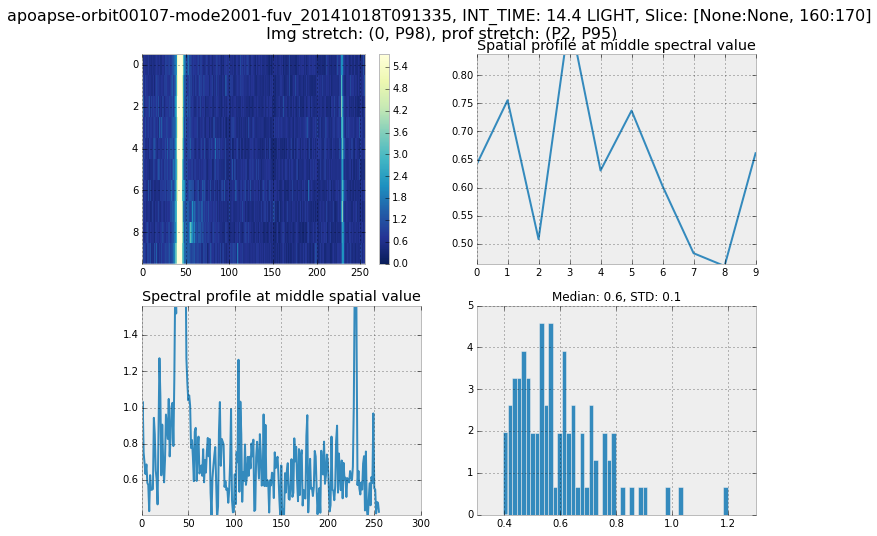

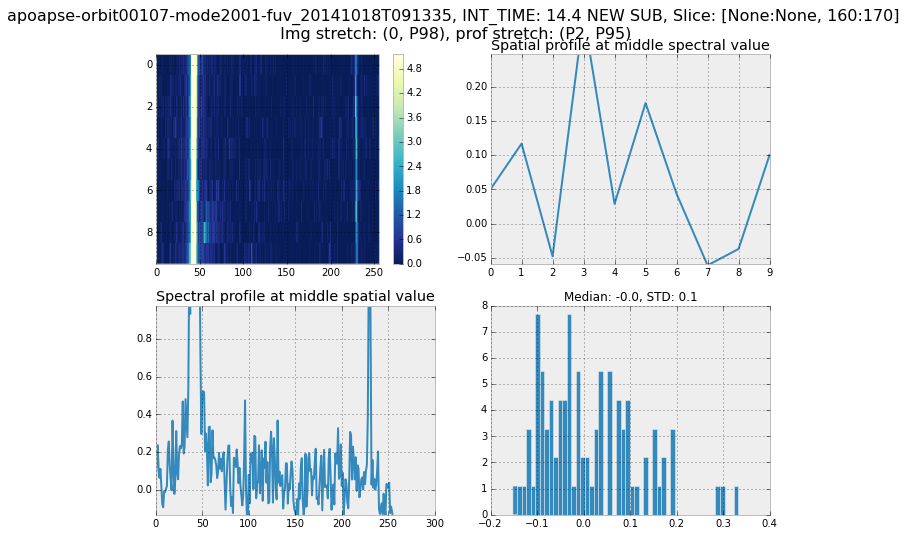

In [24]:
img_profile_and_stats(l1b.get_integration('scaled_raw',-1), l1b, 'LIGHT', spa_slice, spe_slice)
img_profile_and_stats(sub, l1b, 'NEW SUB', spa_slice, spe_slice)